In [5]:
pip install yfinance

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Data Load

In [7]:
data = yf.download('^GSPC', start='2022-01-01', end='2023-01-01')
prices = data['Close'].values
returns = np.log(prices[1:] / prices[:-1])

[*********************100%%**********************]  1 of 1 completed


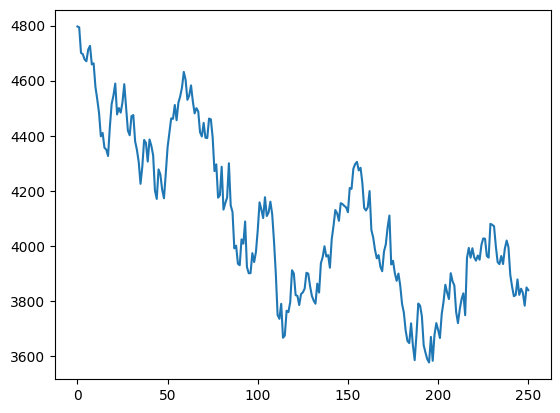

In [59]:
plt.plot(prices)

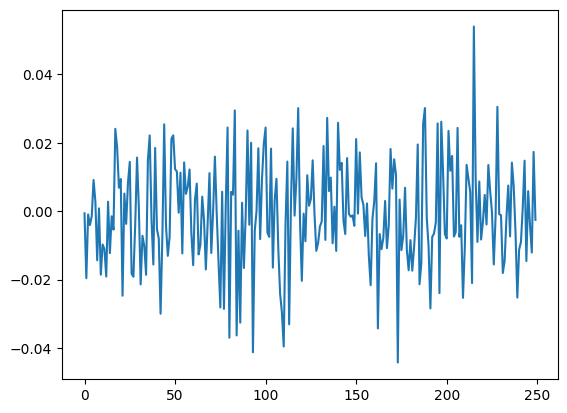

In [61]:
plt.plot(returns)

#Heston Model

https://www.jstor.org/stable/2962057

In [2]:
def heston_simulation(params, S0, r, T, dt, num_paths):
    kappa, theta, sigma, rho, v0 = params

    # Number of time steps
    N = int(T/dt)

    # Initialize stock and variance paths
    S = np.zeros((N+1, num_paths))
    v = np.zeros((N+1, num_paths))
    S[0] = S0
    v[0] = v0

    # Correlated Brownian motions
    dw_v = np.sqrt(dt) * np.random.randn(N, num_paths)
    dw_S = rho * dw_v + np.sqrt(1 - rho**2) * np.sqrt(dt) * np.random.randn(N, num_paths)

    # Euler-Maruyama method
    for t in range(1, N+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * dw_S[t-1])
        v[t] = v[t-1] + kappa * (theta - np.maximum(0, v[t-1])) * dt + sigma * np.sqrt(np.maximum(0, v[t-1])) * dw_v[t-1]

    return S, v

In [8]:
# Parameters and initial conditions

params = [2.0, 0.05, 0.2, -0.7, 0.04]
S0 = 1000  # Initial stock price
r = 0.03  # Risk-free rate
T = 1  # Time to maturity in years
dt = 0.01  # Time step
num_paths = 10  # Number of simulation paths

S, v = heston_simulation(params, prices[0], r, 1, 1/len(prices), 1)

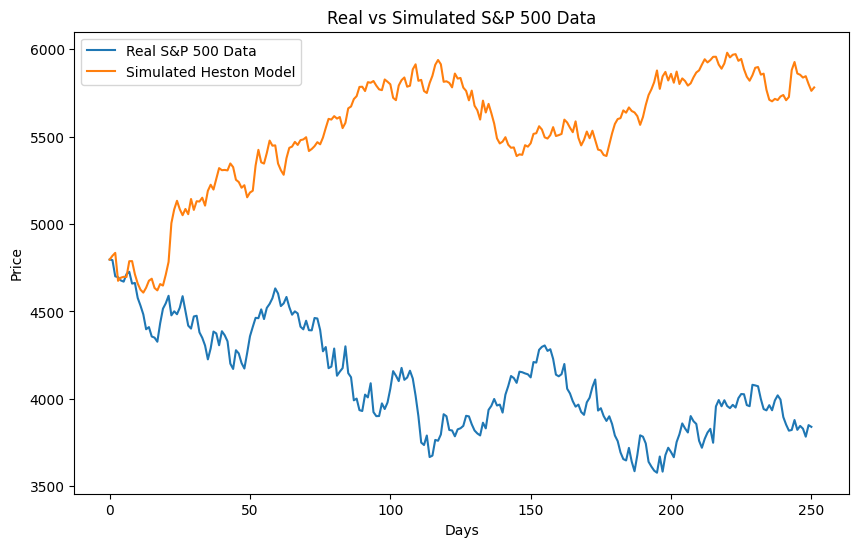

In [9]:
# Plotting the real vs simulated data
plt.figure(figsize=(10, 6))
plt.plot(prices, label="Real S&P 500 Data")
plt.plot(S, label="Simulated Heston Model")
plt.title('Real vs Simulated S&P 500 Data')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

#Heston Model with Maximum Likhood Estimate

https://www.sciencedirect.com/science/article/pii/S0304405X06001395

In [24]:
def heston_log_likelihood(params, returns, dt):

    kappa, theta, sigma, rho, v0 = params
    N = len(returns)
    v = np.zeros(N)
    v[0] = v0
    likelihood = 0

    for t in range(1, N):
        # Euler-Maruyama discretization
        v_mean = v[t-1] + kappa * (theta - max(v[t-1], 0)) * dt
        v[t] = v_mean + sigma * np.sqrt(np.maximum(v[t-1], 0) * dt) * np.random.randn()

        # Log-likelihood calculation
        vol = np.sqrt(v[t])
        likelihood += -0.5 * (np.log(2 * np.pi * vol**2 * dt) + (returns[t-1]**2) / (vol**2 * dt))

    return -likelihood  # We want to maximize likelihood, so return negative for minimization

In [25]:
def calibrate_heston_MLE(returns, initial_params, dt):
    result = minimize(heston_log_likelihood, initial_params, args=(returns, dt))
    return result.x

In [26]:
initial_params = [2.0, 0.05, 0.2, -0.7, 0.04]
params_MLE = calibrate_heston_MLE(returns, initial_params, dt=sum(returns)/len(returns))
S, v = heston_simulation(params_MLE, prices[0], 0.03, 1, 1/len(prices), 1)

<ipython-input-24-481361aaaf12>:12: RuntimeWarning: invalid value encountered in sqrt
  v[t] = v_mean + sigma * np.sqrt(np.maximum(v[t-1], 0) * dt) * np.random.randn()


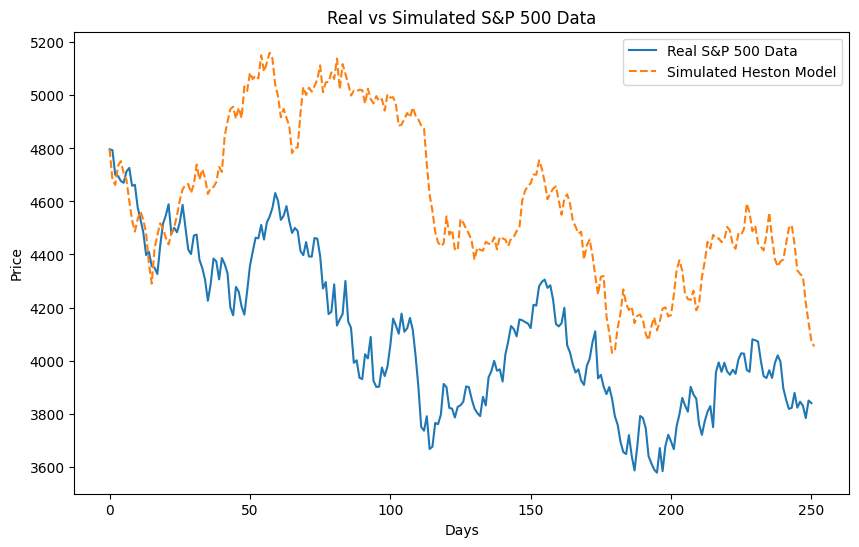

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(prices, label="Real S&P 500 Data")
plt.plot(S, label="Simulated Heston Model", linestyle='dashed')
plt.title('Real vs Simulated S&P 500 Data')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

#Heston Model with Extend Kaliman Fliter

https://www.sciencedirect.com/science/article/pii/S2405896317324758

In [50]:
# Robust Heston dynamics with both ds and dv
def heston_dynamics(x, dt, w):
    S, v, kappa, theta, sigma, rho = x
    dW_S = w[0]
    dW_v = rho * w[0] + np.sqrt(1 - rho**2) * w[1]

    dS = S * np.sqrt(np.maximum(v, 0)) * dW_S
    dv = kappa * (theta - v) * dt + sigma * np.sqrt(np.maximum(v, 0)) * dW_v

    return np.array([S + dS, np.maximum(v + dv, 0), kappa, theta, sigma, rho])

# Heston measurement function (adjusted for the new state vector)
def heston_measurement(x, w):
    S, v, kappa, theta, sigma, rho = x
    return np.sqrt(v) * w

In [51]:
# Compute Jacobian using numerical differentiation
def compute_jacobian(f, x, h=1e-5, *args):
    n = len(x)
    m = len(f(x, *args))
    J = np.zeros((m, n))
    for i in range(n):
        x_perturbed = x.copy()
        x_perturbed[i] += h
        J[:, i] = (f(x_perturbed, *args) - f(x, *args)) / h
    return J

In [52]:
# Extended Kalman Filter (adjusted for the new state vector)
def extended_kalman_filter(Y, x0, P0, Q, R, dt):
    n = len(x0)
    m = len(Y[0])
    N = len(Y)
    X = np.zeros((N, n))
    X[0] = x0
    P = P0
    for k in range(1, N):
        # Prediction
        x_hat = heston_dynamics(X[k-1], dt, np.random.randn(2))
        F = compute_jacobian(lambda x: heston_dynamics(x, dt, np.random.randn(2)), X[k-1])
        P = F @ P @ F.T + Q
        # Update
        z_hat = heston_measurement(x_hat, np.random.randn(1))
        H = compute_jacobian(heston_measurement, x_hat, 1e-5, np.random.randn(1))
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        X[k] = x_hat + K @ (Y[k] - z_hat)
        P = (np.eye(n) - K @ H) @ P + 1e-6 * np.eye(n)
    return X

In [53]:
initial_price = prices[0]
x0 = np.array([initial_price, 0.04, 2.0, 0.05, 0.2, -0.7])
P0 = np.eye(6) * 0.1
Q = np.eye(6) * 0.01
R = np.array([[0.01]])
dt = 1

# Run EKF on S&P 500 returns
X = extended_kalman_filter(returns.reshape(-1, 1), x0, P0, Q, R, dt)

<ipython-input-50-6015ee0daf30>:5: RuntimeWarning: invalid value encountered in sqrt
  dW_v = rho * w[0] + np.sqrt(1 - rho**2) * w[1]


In [57]:
X[:, 0]

array([ 4.79656006e+03,  2.20489057e+03,  2.31881802e+03,  7.61381872e+10,
        9.36381982e+10,  1.14158891e+23, -6.30221150e+40, -5.86706621e+40,
       -2.99860700e+40,  4.13725568e+40,  4.13725568e+40,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

In [55]:
# Extract the stock price and variance process for plotting
predicted_prices = X[:, 0]
predicted_variance = X[:, 1]

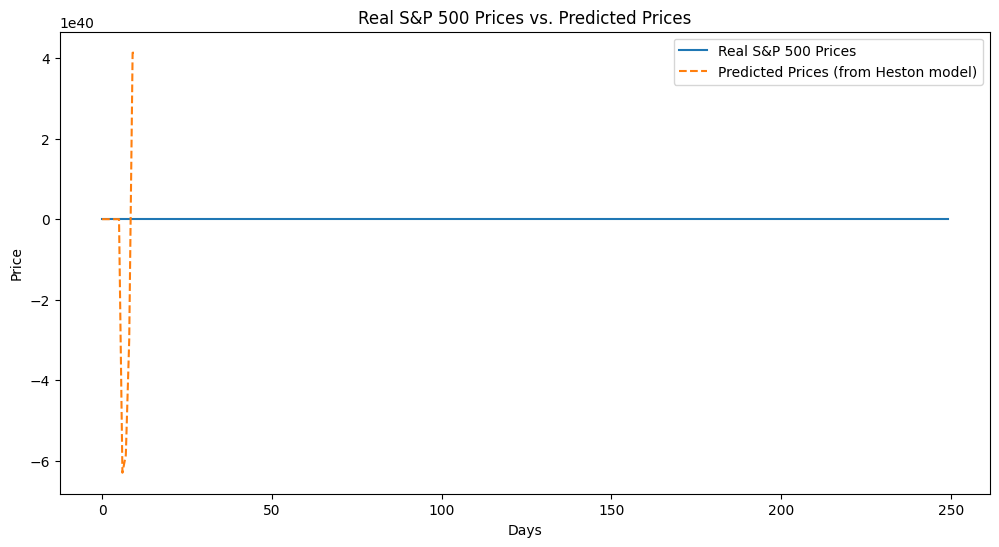

In [56]:
# Plotting the real prices vs. predicted prices and variance
plt.figure(figsize=(12, 6))
plt.plot(prices[1:], label="Real S&P 500 Prices")
plt.plot(predicted_prices, label="Predicted Prices (from Heston model)", linestyle='dashed')
plt.title('Real S&P 500 Prices vs. Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Heston Model smooth with Unscented Kalman Filter

https://www.sciencedirect.com/science/article/pii/S0167947311002015


In [62]:
# Heston parameters
mu = 0.05
kappa = 1.5
theta = 0.04
sigma = 0.5
rho = -0.8
dt = 1.0  # Assuming daily observations
# UKF parameters
alpha = 1e-3
beta = 2
kappa_ukf = 0
n = 2

In [63]:
def heston_dynamics(x, dt):
    """Heston dynamics for a small dt"""
    dS = mu * x[0] * dt
    dV = kappa * (theta - x[1]) * dt
    return np.array([x[0] + dS, x[1] + dV])

In [64]:
def compute_sigma_points(mean, covariance):
    lambda_ = alpha**2 * (n + kappa_ukf) - n
    scaling_factor = np.sqrt(n + lambda_)
    chol = np.linalg.cholesky(covariance)

    sigma_points = [mean]
    for i in range(n):
        sigma_points.append(mean + scaling_factor * chol[:, i])
        sigma_points.append(mean - scaling_factor * chol[:, i])

    return np.array(sigma_points)

In [65]:
def predict(sigma_points):
    mean_predicted = np.zeros(n)
    for point in sigma_points:
        mean_predicted += heston_dynamics(point, dt)
    mean_predicted /= len(sigma_points)

    covariance_predicted = np.zeros((n, n))
    for point in sigma_points:
        diff = point - mean_predicted
        covariance_predicted += np.outer(diff, diff)
    covariance_predicted /= len(sigma_points)

    return mean_predicted, covariance_predicted

In [66]:
def update(mean_predicted, covariance_predicted, observation):
    sigma_points = compute_sigma_points(mean_predicted, covariance_predicted)

    lambda_ = alpha**2 * (n + kappa_ukf) - n
    Wm = np.full(2*n+1, 1. / (2 * (n + lambda_)))
    Wm[0] = lambda_ / (n + lambda_)
    Wc = np.copy(Wm)
    Wc[0] += (1 - alpha**2 + beta)

    observations = np.mean(sigma_points, axis=0)

    covariance_yy = sum(Wc[i] * np.outer(sigma_points[i] - observations, sigma_points[i] - observations) for i in range(2*n+1))
    covariance_xy = sum(Wc[i] * np.outer(sigma_points[i] - mean_predicted, sigma_points[i] - observations) for i in range(2*n+1))

    K = np.linalg.solve(covariance_yy, covariance_xy.T).T

    mean_updated = mean_predicted + K @ (observation - observations)
    covariance_updated = covariance_predicted - K @ covariance_yy @ K.T

    return mean_updated, covariance_updated

In [69]:
initial_mean = np.array([prices[0], 0.02])
initial_covariance = np.eye(2)

current_mean = initial_mean
current_covariance = initial_covariance

estimated_prices = []
estimated_variances = []

for idx, price in enumerate(prices[1:], start=1):
    observation = np.array([price, returns[idx-1]])
    epsilon = 1e-6 # Regularize the covariance matrix
    regularized_covariance = current_covariance + epsilon * np.eye(current_covariance.shape[0])

    sigma_points = compute_sigma_points(current_mean, regularized_covariance)
    mean_predicted, covariance_predicted = predict(sigma_points)
    current_mean, current_covariance = update(mean_predicted, covariance_predicted, observation)
    estimated_prices.append(current_mean[0])
    estimated_variances.append(current_mean[1])

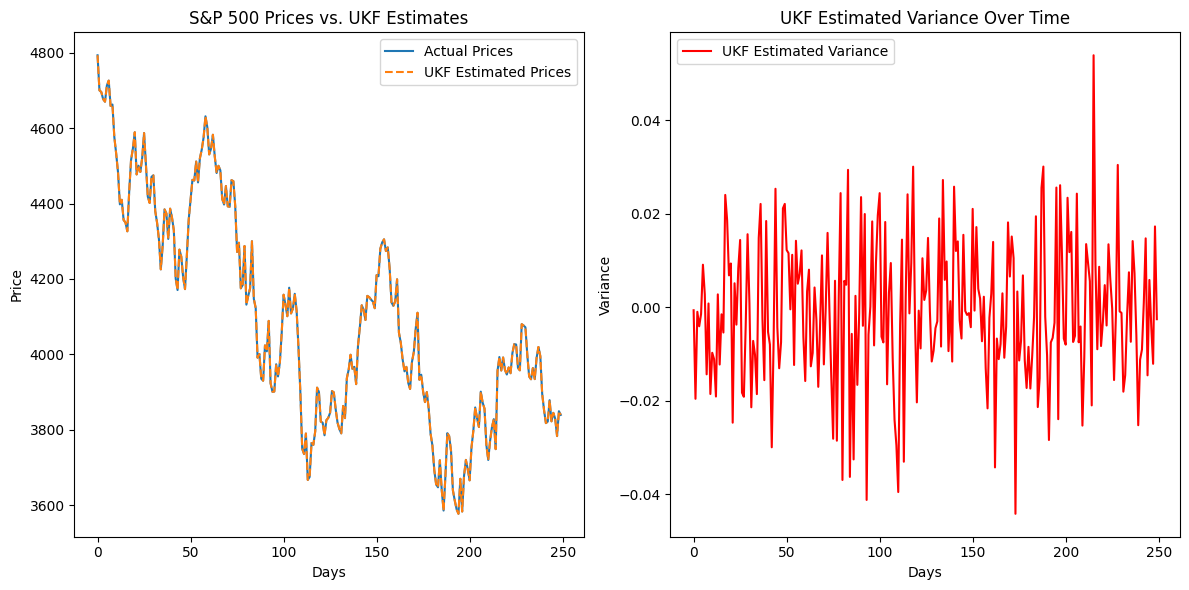

In [70]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plotting the prices
plt.subplot(1, 2, 1)
plt.plot(prices[1:], label='Actual Prices')
plt.plot(estimated_prices, label='UKF Estimated Prices', linestyle='--')
plt.legend()
plt.title('S&P 500 Prices vs. UKF Estimates')
plt.xlabel('Days')
plt.ylabel('Price')

# Plotting the estimated variance
plt.subplot(1, 2, 2)
plt.plot(estimated_variances, label='UKF Estimated Variance', color='red')
plt.legend()
plt.title('UKF Estimated Variance Over Time')
plt.xlabel('Days')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()

# Kalman Filter with Maximum Maximum Likhood Estimate in Heston

https://www.sciencedirect.com/science/article/pii/S0960077921002769

#Kalman Filter with Long Short Term Memory in Heston

https://arxiv.org/abs/2105.00250

#Kalman Filter with Transformer in Heston

https://arxiv.org/abs/2105.00250

#Kalman Filter with LSTM & Transformer in Heston

https://arxiv.org/abs/2105.00250

#Kalman Filter with Optimal Transport in Heston

https://ieeexplore.ieee.org/abstract/document/9992776/authors#authors

#Heston-Nandi Garch Model

https://www.jstor.org/stable/2645997